# RuMedSymptomRec

RuMedSymptomRec[1] - задача рекомендации симптомов по неполноценному медицинскому тексту.

## **Структура решения:**

1. Описание задачи и предметной области
1. Реализация метрики Hit@K
1. Подготовка данных
1. Функция для обучения модели
1. RuBERT
1. RuBioRoBERTa
1. rubert-base-cased-mcn
1. sagteam/xlm-roberta-large-sag
1. FacebookAI/xlm-roberta-large
1. Пример работы модели RuBioRoBERTa
1. Результаты
1. Ссылки на источники


## **1) Описание задачи и предметной области**

### Постановка задачи

По предложенному медицинскому тексту необходимо найти наиболее релевантый(точный) симптом. Количество возможных симптомов ограничено - можно предложить один из 141-го. В следствие этого задачу можно решать как задачу многоклассовой классификации .

### Данные
Данные[2] были получены из Сибирского государственного медицинского университета. Датасет состоит из 3300 примеров, разделенных на тренировочную, валидационную и тестовую модель(2470, 415, 415). Каждый пример представляет собой словарь:
> {'idx': 'q0d8323b',
> 'symptoms': 'на головокружение головную боль в области виска лба, заложенность носа, жар',
> 'code': 'головная боль в области лба'}.

 Где 'idx' - id текста, 'symptoms' - сам текст и 'code' - симптом которой надо предсказать(один из 141 предложенных таргетов).

### Метрики
Задача сводится к классификации текстов. Для каждого текста предложено выбрать один из 141-го симптомов.
Метрики предложенные организаторами - accuracy(hit@1) и hit@3.

$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, hit(y_i, top_i^k),$$

Было принято решение использовать такие же для оценки моделей.

### Модели

В качестве базовой модели была выбрана предобученная модель DeepPavlov/rubert-base-cased [3]. Это Bert предобученный на русском языке(википедия и новости). Состоит из 12 encoder слоев. В общей сложности 180М параметров.
Продвинутая модель - alexyalunin/RuBioRoBERTa [4]. RuBioRoBERTa - предобученная на русских медицинских текстах.
А также: rubert-base-cased-mcn, sagteam/xlm-roberta-large-sag, FacebookAI/xlm-roberta-large


Модель принимает на вход токены(полученные предварительно с помощью токенайзера) и выдает числа(логиты) для каждого класса. Логиты ранжируются в порядке убывания. Класс который оказался на 1 месте - есть искомый симптом. Если надо получить несколько наиболее релевантных - берется топ@k.


Результаты[5] показанные организаторами на тестовой выборке: acc/hit@3  
* RuBERT: 18.55/34.22
* RuBioRoBERTa : 44.01/58.95








In [8]:
import gc
import os
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import unittest

import random

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer,RobertaForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
from transformers.optimization import AdamW

from scipy.special import expit
from keras.preprocessing.sequence import pad_sequences
import sentencepiece
import matplotlib.pyplot as plt
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [10]:
import torch

In [11]:
MAX_LEN=256

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **2) Реализация метрики Hit@K**

In [13]:
def hit_at_n(y_true, y_pred, index2label, n=3):
    assert len(y_true) == len(y_pred)
    hit_count = 0
    for l, row in zip(y_true, y_pred):
        order = (np.argsort(row)[::-1])[:n]
        order = [index2label[i] for i in order]
        order = set(order)
        hit_count += int(l in order)
    return hit_count/float(len(y_true))

## **3) Подготовка данных**

In [14]:
data_path = '/home/kirill/Bert_v2/data'

In [15]:
def encode_texts(tokenizer, sentences):
    bs = 20000
    input_ids, attention_masks = [], []
    for _, i in enumerate(range(0, len(sentences), bs)):
        b_sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences[i:i+bs]]
        tokenized_texts = [tokenizer.tokenize(sent) for sent in b_sentences]
        b_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        b_input_ids = pad_sequences(b_input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
        b_attention_masks = []
        for seq in b_input_ids:
            seq_mask = [float(i>0) for i in seq]
            b_attention_masks.append(seq_mask)

        attention_masks.append(b_attention_masks)
        input_ids.append(b_input_ids)
    input_ids, attention_masks = np.vstack(input_ids), np.vstack(attention_masks)
    return input_ids, attention_masks

## **4) Функция для обучения модели**

In [83]:
def train_model(model, tokenizer, epochs, batch_size, lr, data_path):
   
    text1_id, label_id, index_id = 'symptoms', 'code', 'idx'
    parts = ['train', 'dev', 'test']
    

    part2indices = {p:set() for p in parts}
    all_ids, sentences, labels = [], [], []
    for p in parts:
        fname = '{}_v1.jsonl'.format(p)
        with open(os.path.join(data_path, fname)) as f:
            for line in f:
                data = json.loads(line)
                s1 = data[text1_id]
                sentences.append( s1 )
                labels.append( data[label_id] )
                idx = data[index_id]
                all_ids.append( idx )
                part2indices[p].add( idx )
    all_ids = np.array(all_ids)
    print ('len(total)', len(sentences))

    
    code_set = set(labels)
    l2i = {code:i for i, code in enumerate(sorted(code_set))}
    i2l = {l2i[l]:l for l in l2i}
    print ( 'len(l2i)', len(l2i) )
    
    
    input_ids, attention_masks = encode_texts(tokenizer, sentences)
    
    label_indices = np.array([l2i[l] for l in labels])
    labels = np.zeros((input_ids.shape[0], len(l2i)))
    for _, i in enumerate(label_indices):
        labels[_, i] = 1
        
    print(len(set(part2indices['test']) & set(part2indices['dev']) | set(part2indices['test']) & set(part2indices['train'])))

    test_ids = part2indices['test']
    test_mask = np.array([sid in test_ids for sid in all_ids])
    test_ids = all_ids[test_mask]
    tst_inputs, tst_masks, tst_labels = input_ids[test_mask], attention_masks[test_mask], labels[test_mask]

    tst_inputs = torch.tensor(tst_inputs)
    tst_masks = torch.tensor(tst_masks)
    tst_labels = torch.tensor(tst_labels)

    test_data = TensorDataset(tst_inputs, tst_masks, tst_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=8)


    train_ids = part2indices['train']
    dev_ids = part2indices['dev']

    train_mask = np.array([sid in train_ids for sid in all_ids])
    dev_mask = np.array([sid in dev_ids for sid in all_ids])

    input_ids_train, attention_masks_train, labels_train = input_ids[train_mask], attention_masks[train_mask], labels[train_mask]
    input_ids_dev, attention_masks_dev, labels_dev = input_ids[dev_mask], attention_masks[dev_mask], labels[dev_mask]

    input_ids_train = torch.tensor(input_ids_train)
    attention_masks_train = torch.tensor(attention_masks_train)
    labels_train = torch.tensor(labels_train)

    train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    input_ids_dev = torch.tensor(input_ids_dev)
    attention_masks_dev = torch.tensor(attention_masks_dev)
    labels_dev = torch.tensor(labels_dev)

    prediction_data = TensorDataset(input_ids_dev, attention_masks_dev, labels_dev)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    
    max_grad_norm = 1.5
    
    
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]

    # This variable contains all of the hyperparemeter information our training loop needs
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr, correct_bias=False)
    
    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)
    #criterion = nn.CrossEntropyLoss()
    
    
    #TRAIN
    metrics = {'val': {'acc' : [], 'hit3' : [], 'hit5' : [], 'losses' : []},
               'train' : {'acc' : [], 'hit3' : [], 'hit5': [], 'losses' : []}}
    
    best_score_val = 0
    best_hit3 = 0
    best_acc = 0
    
    for i in tqdm(range(epochs)):
        model.train(); torch.cuda.empty_cache()
        p_pred_train = []
        y_pred_train = []
        losses = 0
        losses_step = 0
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()

            outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
            p_pred_train.extend(logits.detach().cpu().numpy())
            y_pred_train.extend(b_labels.detach().cpu().numpy())
            #loss = criterion(logits, b_labels.to(device))
            losses += loss.item()
            losses_step += 1
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
        
        metrics['train']['losses'].append(losses / float(losses_step))
        
        #y_indices = np.argmax(labels_train.detach().cpu().numpy(), axis=1)
        #dev_codes = [i2l[i] for i in y_indices]
        
        dev_codes = [i2l[i] for i in np.argmax(y_pred_train, axis=1)]
        
        metrics['train']['hit3'].append(hit_at_n(dev_codes, p_pred_train, i2l, 3))
        metrics['train']['hit5'].append(hit_at_n(dev_codes, p_pred_train, i2l, 5))
        metrics['train']['acc'].append(hit_at_n(dev_codes, p_pred_train, i2l, 1))

        model.eval()
        p_pred_val = []
        losses = 0
        losses_step = 0
        for step, batch in enumerate(prediction_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels )
                loss, logits = outputs[:2]
                losses += loss.item()
                losses_step += 1
            p_pred_val.extend(logits.detach().cpu().numpy())

    
        y_indices = np.argmax(labels_dev.detach().cpu().numpy(), axis=1)
        dev_codes_val = [i2l[i] for i in y_indices]
        
        acc = hit_at_n(dev_codes_val, p_pred_val, i2l, 1)
        hit3 = hit_at_n(dev_codes_val, p_pred_val, i2l, 3)
        
            
        metrics['val']['losses'].append(losses / float(losses_step))
        metrics['val']['hit3'].append(hit3)
        metrics['val']['acc'].append(acc)    
        metrics['val']['hit5'].append(hit_at_n(dev_codes_val, p_pred_val, i2l, 5))
        
        if ((acc + hit3) / 2) > best_score_val:
            best_score_val = (acc + hit3) / 2
            best_epoch_val = i

            p_pred_test = []
            true_labels = []
            for step, batch in enumerate(test_dataloader):
                batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                with torch.no_grad():
                    outputs = model( b_input_ids, attention_mask=b_input_mask, labels=b_labels )
                logits = outputs[1]
                p_pred_test.extend(logits.detach().cpu().numpy())

            y_indices = np.argmax(tst_labels.detach().cpu().numpy(), axis=1)
            dev_codes_test = [i2l[i] for i in y_indices]
            
            best_hit3 = hit_at_n(dev_codes_test, p_pred_test, i2l, 3)
            best_acc = hit_at_n(dev_codes_test, p_pred_test, i2l,  1)
            
                
            print('UPDATE: epoch = ', i, 'best_acc = ', best_acc, 'best_hit3 = ', best_hit3)  

        print('epoch ', i, 'train_loss',  metrics['train']['losses'][-1], metrics['val']['losses'][-1], 'val acc',
               metrics['val']['acc'][-1], 'val hit3', metrics['val']['hit3'][-1])
    return model, metrics, best_epoch_val, best_hit3, best_acc    

In [84]:
def plot_metrics(metrics, name):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    fig.suptitle(name, fontsize=16)
    titles = ['Accuracy', 'Hit@3', 'Hit@5', 'Losses']

    metrics_names = ['acc', 'hit3', 'hit5', 'losses']

    for i, metric_name in enumerate(metrics_names):
        row = i // 2
        col = i % 2

        axs[row][col].plot(metrics['train'][metric_name], label='Train', c='g')
        axs[row][col].plot(metrics['val'][metric_name], label='Validation', c='r')

        axs[row][col].set_title(titles[i])
        axs[row][col].set_xlabel('Epochs')
        axs[row][col].set_ylabel(metric_name.capitalize())
        axs[row][col].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## **5) RuBERT**

In [24]:
#import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [64]:
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=141)
model = model.cuda()

tokenizer = BertTokenizer.from_pretrained(
    'DeepPavlov/rubert-base-cased', #'alexyalunin/RuBioBERT'
    do_lower_case=True,
    max_length=MAX_LEN
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
device = 'cuda'
torch.tensor(1).to(device)

tensor(1, device='cuda:0')

In [22]:
epochs = 35
batch_size = 4
lr = 4e-5
data_path = '/home/kirill/Bert_v2/data'

### Обучениe модели

In [263]:
model, metrics, best_epoch_val, best_hit3, best_acc= train_model(model, 
                                                    tokenizer, 
                                                    epochs, 
                                                    batch_size, 
                                                    lr, 
                                                    data_path)                                                                                                            

len(total) 3300
len(l2i) 141
0


  3%|▎         | 1/35 [00:58<33:06, 58.43s/it]

UPDATE: epoch =  0 best_acc =  0.007228915662650603 best_hit3 =  0.03132530120481928
epoch  0 train_loss 0.3125044453657591 val acc 0.004819277108433735 val hit3 0.03855421686746988


  6%|▌         | 2/35 [01:54<31:26, 57.16s/it]

epoch  1 train_loss 0.0962186994169544 val acc 0.004819277108433735 val hit3 0.03855421686746988


  9%|▊         | 3/35 [02:50<30:16, 56.75s/it]

epoch  2 train_loss 0.053849027826231244 val acc 0.004819277108433735 val hit3 0.033734939759036145


 11%|█▏        | 4/35 [03:50<29:58, 58.02s/it]

UPDATE: epoch =  3 best_acc =  0.01927710843373494 best_hit3 =  0.04096385542168675
epoch  3 train_loss 0.044287479242006454 val acc 0.01927710843373494 val hit3 0.04578313253012048


 14%|█▍        | 5/35 [04:49<29:08, 58.27s/it]

UPDATE: epoch =  4 best_acc =  0.01927710843373494 best_hit3 =  0.05542168674698795
epoch  4 train_loss 0.042329214998447176 val acc 0.01927710843373494 val hit3 0.05301204819277108


 17%|█▋        | 6/35 [05:46<27:54, 57.75s/it]

epoch  5 train_loss 0.04215723820212469 val acc 0.021686746987951807 val hit3 0.05060240963855422


 20%|██        | 7/35 [06:43<26:48, 57.45s/it]

epoch  6 train_loss 0.04216611706358792 val acc 0.00963855421686747 val hit3 0.04578313253012048


 23%|██▎       | 8/35 [07:39<25:41, 57.09s/it]

epoch  7 train_loss 0.04221683893632422 val acc 0.021686746987951807 val hit3 0.04096385542168675


 26%|██▌       | 9/35 [08:38<24:56, 57.54s/it]

UPDATE: epoch =  8 best_acc =  0.04578313253012048 best_hit3 =  0.0963855421686747
epoch  8 train_loss 0.0421395214174615 val acc 0.04096385542168675 val hit3 0.07710843373493977


 29%|██▊       | 10/35 [09:36<24:05, 57.82s/it]

UPDATE: epoch =  9 best_acc =  0.05542168674698795 best_hit3 =  0.12048192771084337
epoch  9 train_loss 0.04177794876419085 val acc 0.03614457831325301 val hit3 0.09156626506024096


 31%|███▏      | 11/35 [10:35<23:14, 58.12s/it]

UPDATE: epoch =  10 best_acc =  0.060240963855421686 best_hit3 =  0.14216867469879518
epoch  10 train_loss 0.04083274915530872 val acc 0.03614457831325301 val hit3 0.10120481927710843


 34%|███▍      | 12/35 [11:33<22:19, 58.24s/it]

UPDATE: epoch =  11 best_acc =  0.04819277108433735 best_hit3 =  0.12771084337349398
epoch  11 train_loss 0.03964687908786656 val acc 0.02891566265060241 val hit3 0.1108433734939759


 37%|███▋      | 13/35 [12:30<21:13, 57.89s/it]

epoch  12 train_loss 0.038610358124562476 val acc 0.033734939759036145 val hit3 0.09156626506024096


 40%|████      | 14/35 [13:29<20:19, 58.10s/it]

UPDATE: epoch =  13 best_acc =  0.08433734939759036 best_hit3 =  0.17590361445783131
epoch  13 train_loss 0.03767438320556629 val acc 0.04578313253012048 val hit3 0.1493975903614458


 43%|████▎     | 15/35 [14:26<19:12, 57.62s/it]

epoch  14 train_loss 0.03641020186855422 val acc 0.04819277108433735 val hit3 0.13734939759036144


 46%|████▌     | 16/35 [15:22<18:08, 57.27s/it]

epoch  15 train_loss 0.03510174058975751 val acc 0.043373493975903614 val hit3 0.12771084337349398


 49%|████▊     | 17/35 [16:20<17:15, 57.51s/it]

UPDATE: epoch =  16 best_acc =  0.10602409638554217 best_hit3 =  0.2385542168674699
epoch  16 train_loss 0.0337343738712561 val acc 0.06265060240963856 val hit3 0.1566265060240964


 51%|█████▏    | 18/35 [17:19<16:24, 57.92s/it]

UPDATE: epoch =  17 best_acc =  0.1108433734939759 best_hit3 =  0.25060240963855424
epoch  17 train_loss 0.03219142963972506 val acc 0.07710843373493977 val hit3 0.21204819277108433


 54%|█████▍    | 19/35 [18:20<15:41, 58.87s/it]

UPDATE: epoch =  18 best_acc =  0.12771084337349398 best_hit3 =  0.27710843373493976
epoch  18 train_loss 0.03042036113653183 val acc 0.10120481927710843 val hit3 0.23373493975903614


 57%|█████▋    | 20/35 [19:18<14:40, 58.72s/it]

UPDATE: epoch =  19 best_acc =  0.13734939759036144 best_hit3 =  0.30120481927710846
epoch  19 train_loss 0.028856401964681793 val acc 0.09879518072289156 val hit3 0.24096385542168675


 60%|██████    | 21/35 [20:15<13:34, 58.18s/it]

epoch  20 train_loss 0.02702493071197832 val acc 0.0963855421686747 val hit3 0.21927710843373494


 63%|██████▎   | 22/35 [21:13<12:35, 58.13s/it]

UPDATE: epoch =  21 best_acc =  0.163855421686747 best_hit3 =  0.3180722891566265
epoch  21 train_loss 0.025236615000687718 val acc 0.10602409638554217 val hit3 0.2385542168674699


 66%|██████▌   | 23/35 [22:10<11:32, 57.67s/it]

UPDATE: epoch =  22 best_acc =  0.17349397590361446 best_hit3 =  0.327710843373494
epoch  22 train_loss 0.023524614067892653 val acc 0.1180722891566265 val hit3 0.2674698795180723


 69%|██████▊   | 24/35 [23:09<10:38, 58.09s/it]

UPDATE: epoch =  23 best_acc =  0.17349397590361446 best_hit3 =  0.3397590361445783
epoch  23 train_loss 0.021933600599370138 val acc 0.14216867469879518 val hit3 0.25301204819277107


 71%|███████▏  | 25/35 [24:08<09:42, 58.29s/it]

UPDATE: epoch =  24 best_acc =  0.18072289156626506 best_hit3 =  0.3397590361445783
epoch  24 train_loss 0.02040413667668742 val acc 0.13012048192771083 val hit3 0.2674698795180723


 74%|███████▍  | 26/35 [25:07<08:46, 58.49s/it]

UPDATE: epoch =  25 best_acc =  0.1783132530120482 best_hit3 =  0.327710843373494
epoch  25 train_loss 0.018944242882893234 val acc 0.13734939759036144 val hit3 0.2819277108433735


 77%|███████▋  | 27/35 [26:06<07:49, 58.68s/it]

UPDATE: epoch =  26 best_acc =  0.18072289156626506 best_hit3 =  0.3542168674698795
epoch  26 train_loss 0.017730134596208584 val acc 0.163855421686747 val hit3 0.2819277108433735


 80%|████████  | 28/35 [27:04<06:50, 58.68s/it]

UPDATE: epoch =  27 best_acc =  0.19036144578313252 best_hit3 =  0.3493975903614458
epoch  27 train_loss 0.016544193932224283 val acc 0.1686746987951807 val hit3 0.28674698795180725


 83%|████████▎ | 29/35 [28:04<05:53, 58.84s/it]

UPDATE: epoch =  28 best_acc =  0.18795180722891566 best_hit3 =  0.3469879518072289
epoch  28 train_loss 0.015683798013530023 val acc 0.163855421686747 val hit3 0.3036144578313253


 86%|████████▌ | 30/35 [29:02<04:54, 58.80s/it]

UPDATE: epoch =  29 best_acc =  0.1783132530120482 best_hit3 =  0.3397590361445783
epoch  29 train_loss 0.014939962191816605 val acc 0.17590361445783131 val hit3 0.2963855421686747


 89%|████████▊ | 31/35 [30:01<03:54, 58.60s/it]

UPDATE: epoch =  30 best_acc =  0.18795180722891566 best_hit3 =  0.3469879518072289
epoch  30 train_loss 0.014410252423963545 val acc 0.1710843373493976 val hit3 0.3036144578313253


 91%|█████████▏| 32/35 [30:59<02:55, 58.50s/it]

UPDATE: epoch =  31 best_acc =  0.1927710843373494 best_hit3 =  0.3397590361445783
epoch  31 train_loss 0.014023592512317643 val acc 0.16626506024096385 val hit3 0.3132530120481928


 94%|█████████▍| 33/35 [31:57<01:56, 58.44s/it]

UPDATE: epoch =  32 best_acc =  0.1927710843373494 best_hit3 =  0.344578313253012
epoch  32 train_loss 0.013805906297667014 val acc 0.1783132530120482 val hit3 0.3060240963855422


 97%|█████████▋| 34/35 [32:55<00:58, 58.16s/it]

epoch  33 train_loss 0.013684970512915638 val acc 0.17349397590361446 val hit3 0.3060240963855422


100%|██████████| 35/35 [33:51<00:00, 58.05s/it]

epoch  34 train_loss 0.013674314087138147 val acc 0.17349397590361446 val hit3 0.3036144578313253


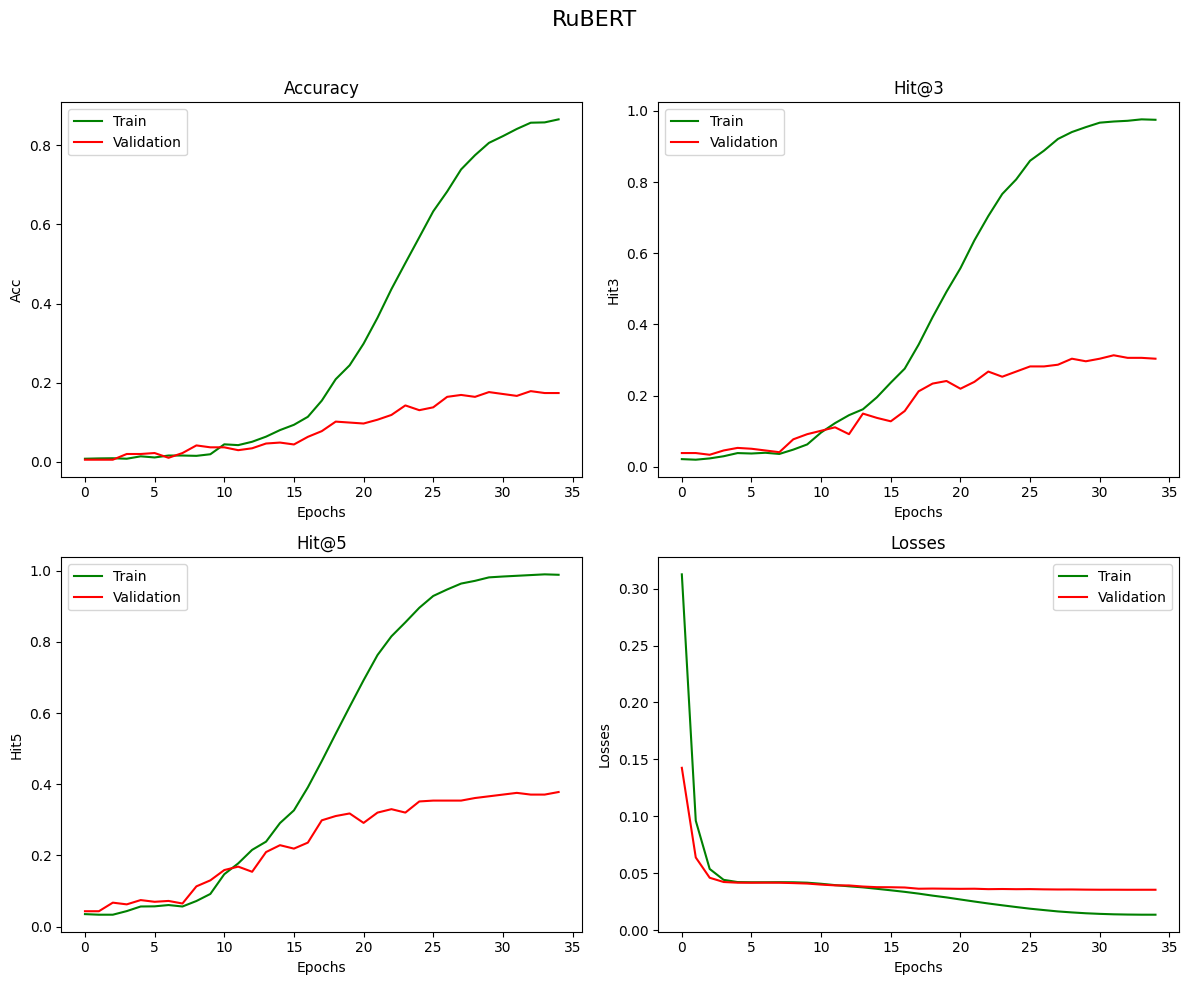

In [264]:
plot_metrics(metrics, 'RuBERT')

In [265]:
best_epoch_val, best_acc, best_hit3

(32, 0.1927710843373494, 0.344578313253012)

In [266]:
model.save_pretrained('out_path/rubert1')

In [273]:
del model; 
gc.collect(); 
torch.cuda.empty_cache()

## **6. RuBioRoBERTa**

In [111]:
model = RobertaForSequenceClassification.from_pretrained('alexyalunin/RuBioRoBERTa', num_labels=141)
model = model.cuda()

tokenizer = RobertaTokenizer.from_pretrained(
    'alexyalunin/RuBioRoBERTa',
    do_lower_case=True,
    max_length=MAX_LEN
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at alexyalunin/RuBioRoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Обучениe модели

In [112]:
epochs = 40
batch_size = 8
lr = 2e-5
data_path = '/home/kirill/Bert_v2/data'

In [113]:
model, metrics, best_epoch_val, best_hit3, best_acc= train_model(model, 
                                                    tokenizer, 
                                                    epochs, 
                                                    batch_size, 
                                                    lr, 
                                                    data_path) 

len(total) 3300
len(l2i) 141
0


  2%|▎         | 1/40 [02:21<1:32:13, 141.88s/it]

UPDATE: epoch =  0 best_acc =  0.0 best_hit3 =  0.012048192771084338
epoch  0 train_loss 0.38970449546297165 0.23340295363522737 val acc 0.0024096385542168677 val hit3 0.012048192771084338


  5%|▌         | 2/40 [04:37<1:27:32, 138.22s/it]

epoch  1 train_loss 0.17677562292273638 0.11855576571514644 val acc 0.0 val hit3 0.014457831325301205


  8%|▊         | 3/40 [06:52<1:24:24, 136.88s/it]

epoch  2 train_loss 0.094599451268496 0.07029553492171814 val acc 0.0 val hit3 0.014457831325301205


 10%|█         | 4/40 [09:14<1:23:18, 138.83s/it]

UPDATE: epoch =  3 best_acc =  0.004819277108433735 best_hit3 =  0.024096385542168676
epoch  3 train_loss 0.06120557478093539 0.051916115592162616 val acc 0.0 val hit3 0.02891566265060241


 12%|█▎        | 5/40 [11:36<1:21:35, 139.88s/it]

UPDATE: epoch =  4 best_acc =  0.01927710843373494 best_hit3 =  0.024096385542168676
epoch  4 train_loss 0.04877282434097107 0.045233165183165606 val acc 0.01927710843373494 val hit3 0.02650602409638554


 15%|█▌        | 6/40 [13:57<1:19:34, 140.44s/it]

UPDATE: epoch =  5 best_acc =  0.01927710843373494 best_hit3 =  0.03614457831325301
epoch  5 train_loss 0.04432394950267484 0.04286158969694785 val acc 0.01927710843373494 val hit3 0.04096385542168675


 18%|█▊        | 7/40 [16:19<1:17:30, 140.91s/it]

UPDATE: epoch =  6 best_acc =  0.01927710843373494 best_hit3 =  0.04096385542168675
epoch  6 train_loss 0.04269304879790255 0.04206442674656055 val acc 0.01927710843373494 val hit3 0.05060240963855422


 20%|██        | 8/40 [18:35<1:14:14, 139.19s/it]

epoch  7 train_loss 0.042245594668603795 0.04181891893450463 val acc 0.01927710843373494 val hit3 0.05060240963855422


 22%|██▎       | 9/40 [20:50<1:11:18, 138.01s/it]

epoch  8 train_loss 0.042142342242491415 0.041746755349283966 val acc 0.01927710843373494 val hit3 0.05060240963855422


 25%|██▌       | 10/40 [23:12<1:09:36, 139.21s/it]

UPDATE: epoch =  9 best_acc =  0.01927710843373494 best_hit3 =  0.04578313253012048
epoch  9 train_loss 0.04212067071470559 0.04172207308492845 val acc 0.01927710843373494 val hit3 0.05542168674698795


 28%|██▊       | 11/40 [25:35<1:07:47, 140.24s/it]

UPDATE: epoch =  10 best_acc =  0.01927710843373494 best_hit3 =  0.04578313253012048
epoch  10 train_loss 0.04215028008480059 0.04170622457059506 val acc 0.021686746987951807 val hit3 0.05542168674698795


 30%|███       | 12/40 [27:50<1:04:46, 138.80s/it]

epoch  11 train_loss 0.04212955699990135 0.04170751953271793 val acc 0.01927710843373494 val hit3 0.05542168674698795


 32%|███▎      | 13/40 [30:06<1:02:00, 137.81s/it]

epoch  12 train_loss 0.04209852967317026 0.04170856427936391 val acc 0.00963855421686747 val hit3 0.05542168674698795


 35%|███▌      | 14/40 [32:22<59:27, 137.21s/it]  

epoch  13 train_loss 0.0421476626309171 0.041707296774816785 val acc 0.00963855421686747 val hit3 0.05542168674698795


 38%|███▊      | 15/40 [34:37<56:56, 136.65s/it]

epoch  14 train_loss 0.042156729663332324 0.041707799325217135 val acc 0.014457831325301205 val hit3 0.03855421686746988


 40%|████      | 16/40 [36:52<54:30, 136.28s/it]

epoch  15 train_loss 0.04215215884525688 0.041665849253023114 val acc 0.00963855421686747 val hit3 0.05783132530120482


 42%|████▎     | 17/40 [39:08<52:09, 136.06s/it]

epoch  16 train_loss 0.04276580141404769 0.041658878896053575 val acc 0.00963855421686747 val hit3 0.043373493975903614


 45%|████▌     | 18/40 [41:23<49:48, 135.82s/it]

epoch  17 train_loss 0.04207099752223234 0.041565212263394644 val acc 0.012048192771084338 val hit3 0.04578313253012048


 48%|████▊     | 19/40 [43:45<48:11, 137.71s/it]

UPDATE: epoch =  18 best_acc =  0.03132530120481928 best_hit3 =  0.06987951807228916
epoch  18 train_loss 0.04189324750074112 0.041430513239429 val acc 0.021686746987951807 val hit3 0.06506024096385542


 50%|█████     | 20/40 [46:07<46:19, 139.00s/it]

UPDATE: epoch =  19 best_acc =  0.033734939759036145 best_hit3 =  0.08674698795180723
epoch  19 train_loss 0.041715292546928386 0.04113184000625213 val acc 0.02650602409638554 val hit3 0.06987951807228916


 52%|█████▎    | 21/40 [48:29<44:19, 139.98s/it]

UPDATE: epoch =  20 best_acc =  0.04096385542168675 best_hit3 =  0.10602409638554217
epoch  20 train_loss 0.04133626304098472 0.040831566405086346 val acc 0.02891566265060241 val hit3 0.0819277108433735


 55%|█████▌    | 22/40 [50:52<42:13, 140.74s/it]

UPDATE: epoch =  21 best_acc =  0.05783132530120482 best_hit3 =  0.14457831325301204
epoch  21 train_loss 0.04088823067168524 0.04036471506593921 val acc 0.05783132530120482 val hit3 0.12048192771084337


 57%|█████▊    | 23/40 [53:08<39:25, 139.16s/it]

epoch  22 train_loss 0.040250179100127105 0.039842606371241214 val acc 0.043373493975903614 val hit3 0.12530120481927712


 60%|██████    | 24/40 [55:30<37:21, 140.08s/it]

UPDATE: epoch =  23 best_acc =  0.06987951807228916 best_hit3 =  0.163855421686747
epoch  23 train_loss 0.03951529866366606 0.03924304434488006 val acc 0.06265060240963856 val hit3 0.15180722891566265


 62%|██████▎   | 25/40 [57:52<35:10, 140.72s/it]

UPDATE: epoch =  24 best_acc =  0.09156626506024096 best_hit3 =  0.1927710843373494
epoch  24 train_loss 0.03876920846533666 0.03858502943995783 val acc 0.07710843373493977 val hit3 0.1710843373493976


 65%|██████▌   | 26/40 [1:00:14<32:56, 141.20s/it]

UPDATE: epoch =  25 best_acc =  0.09397590361445783 best_hit3 =  0.20481927710843373
epoch  25 train_loss 0.03788630230049187 0.03793190749581749 val acc 0.06746987951807229 val hit3 0.2216867469879518


 68%|██████▊   | 27/40 [1:02:37<30:40, 141.55s/it]

UPDATE: epoch =  26 best_acc =  0.10843373493975904 best_hit3 =  0.22409638554216868
epoch  26 train_loss 0.03687090499708883 0.03748708145868452 val acc 0.07951807228915662 val hit3 0.2216867469879518


 70%|███████   | 28/40 [1:04:59<28:20, 141.72s/it]

UPDATE: epoch =  27 best_acc =  0.12530120481927712 best_hit3 =  0.25060240963855424
epoch  27 train_loss 0.03586685015565756 0.03698366050580947 val acc 0.10120481927710843 val hit3 0.23132530120481928


 72%|███████▎  | 29/40 [1:07:21<26:01, 141.97s/it]

UPDATE: epoch =  28 best_acc =  0.12289156626506025 best_hit3 =  0.26265060240963856
epoch  28 train_loss 0.03492513562378197 0.03642558312276833 val acc 0.10602409638554217 val hit3 0.26024096385542167


 75%|███████▌  | 30/40 [1:09:43<23:40, 142.01s/it]

UPDATE: epoch =  29 best_acc =  0.13493975903614458 best_hit3 =  0.3036144578313253
epoch  29 train_loss 0.03401152959846776 0.03601826136543743 val acc 0.1180722891566265 val hit3 0.27710843373493976


 78%|███████▊  | 31/40 [1:12:06<21:18, 142.08s/it]

UPDATE: epoch =  30 best_acc =  0.15903614457831325 best_hit3 =  0.3204819277108434
epoch  30 train_loss 0.033074382948657624 0.03556914933260427 val acc 0.12771084337349398 val hit3 0.29397590361445786


 80%|████████  | 32/40 [1:14:28<18:56, 142.07s/it]

UPDATE: epoch =  31 best_acc =  0.1710843373493976 best_hit3 =  0.327710843373494
epoch  31 train_loss 0.03238073415586888 0.03526777548940627 val acc 0.14216867469879518 val hit3 0.29156626506024097


 82%|████████▎ | 33/40 [1:16:50<16:35, 142.17s/it]

UPDATE: epoch =  32 best_acc =  0.18795180722891566 best_hit3 =  0.3397590361445783
epoch  32 train_loss 0.03171916988539826 0.034928655490951616 val acc 0.13493975903614458 val hit3 0.3060240963855422


 85%|████████▌ | 34/40 [1:19:13<14:13, 142.32s/it]

UPDATE: epoch =  33 best_acc =  0.20240963855421687 best_hit3 =  0.3686746987951807
epoch  33 train_loss 0.031181311082664535 0.034734733260791434 val acc 0.13734939759036144 val hit3 0.3132530120481928


 88%|████████▊ | 35/40 [1:21:35<11:51, 142.34s/it]

UPDATE: epoch =  34 best_acc =  0.20240963855421687 best_hit3 =  0.38795180722891565
epoch  34 train_loss 0.030636566250253062 0.03460299614820896 val acc 0.14698795180722893 val hit3 0.3325301204819277


 90%|█████████ | 36/40 [1:23:57<09:29, 142.27s/it]

UPDATE: epoch =  35 best_acc =  0.20240963855421687 best_hit3 =  0.39518072289156625
epoch  35 train_loss 0.030327359318696297 0.03451604046399755 val acc 0.1493975903614458 val hit3 0.3349397590361446


 92%|█████████▎| 37/40 [1:26:13<07:01, 140.36s/it]

epoch  36 train_loss 0.03001219458769793 0.034408190193254425 val acc 0.15180722891566265 val hit3 0.3301204819277108


 95%|█████████▌| 38/40 [1:28:29<04:37, 138.95s/it]

epoch  37 train_loss 0.02984897560688268 0.03439687023766198 val acc 0.14216867469879518 val hit3 0.3325301204819277


 98%|█████████▊| 39/40 [1:30:44<02:17, 137.96s/it]

epoch  38 train_loss 0.029813627872597493 0.034382525773357646 val acc 0.14457831325301204 val hit3 0.3325301204819277


100%|██████████| 40/40 [1:33:00<00:00, 139.52s/it]

epoch  39 train_loss 0.02980602370317263 0.034379652715181765 val acc 0.14457831325301204 val hit3 0.3301204819277108


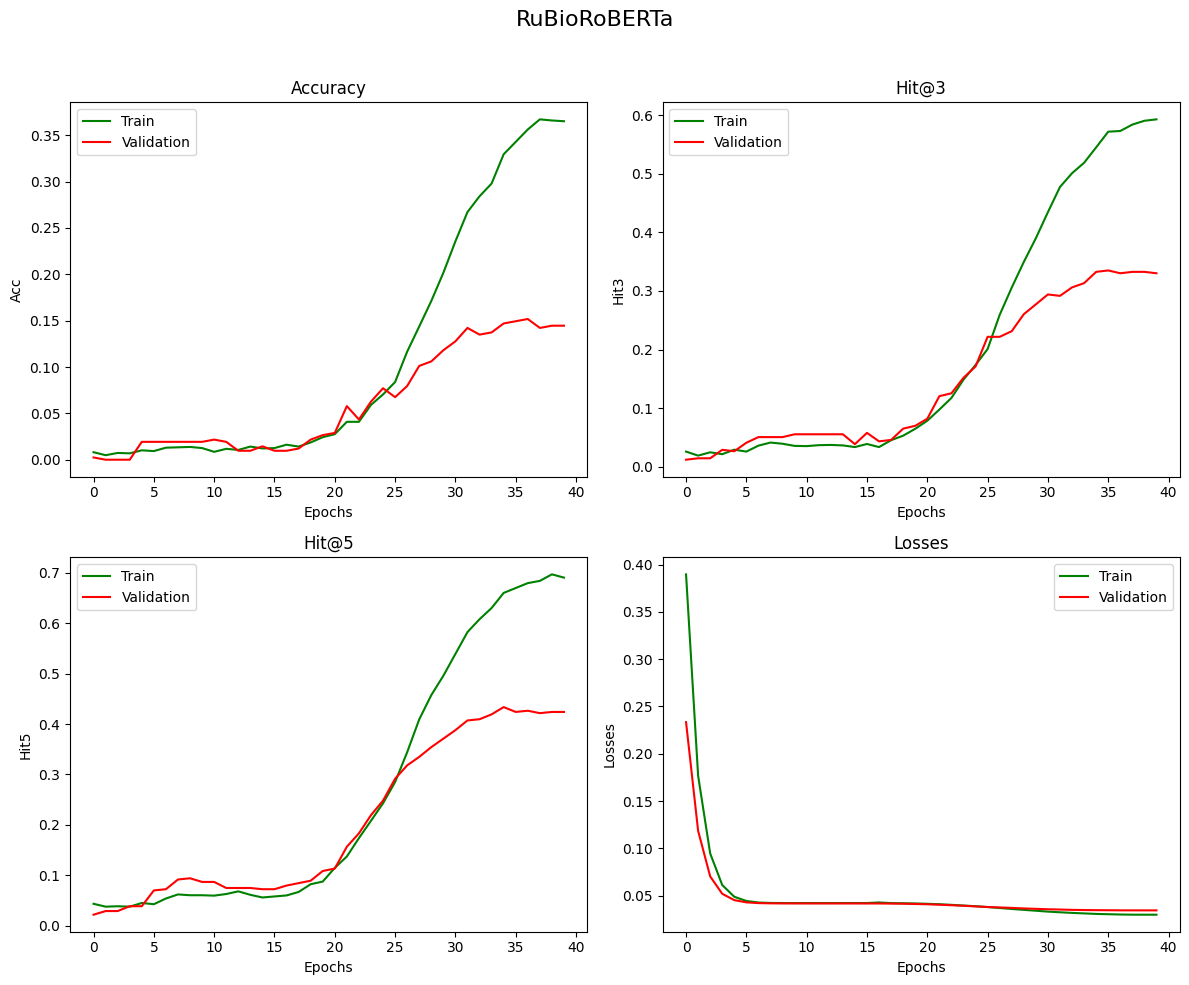

In [114]:
plot_metrics(metrics, 'RuBioRoBERTa')

In [115]:
best_epoch_val, best_acc, best_hit3

(35, 0.20240963855421687, 0.39518072289156625)

In [116]:
model.save_pretrained('out_path/RuBioRoBERTa1')

In [110]:
del model; 
gc.collect(); 
torch.cuda.empty_cache()

## **7. rubert-base-cased-mcn**

In [284]:
model = BertForSequenceClassification.from_pretrained('sagteam/rubert-base-cased-mcn', num_labels=141)
model = model.cuda()

tokenizer = BertTokenizer.from_pretrained(
    'sagteam/rubert-base-cased-mcn', #'alexyalunin/RuBioBERT'
    do_lower_case=True,
    max_length=MAX_LEN
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagteam/rubert-base-cased-mcn and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [285]:
epochs = 35
batch_size = 4
lr = 3e-5
data_path = '/home/kirill/Bert_v2/data'

In [286]:
model, metrics, best_epoch_val, best_hit3, best_acc= train_model(model, 
                                                    tokenizer, 
                                                    epochs, 
                                                    batch_size, 
                                                    lr, 
                                                    data_path) 

len(total) 3300
len(l2i) 141
0


  3%|▎         | 1/35 [00:59<33:56, 59.91s/it]

UPDATE: epoch =  0 best_acc =  0.014457831325301205 best_hit3 =  0.01927710843373494
epoch  0 train_loss 0.39946210016699646 val acc 0.007228915662650603 val hit3 0.00963855421686747


  6%|▌         | 2/35 [01:55<31:41, 57.64s/it]

epoch  1 train_loss 0.1380648414082304 val acc 0.007228915662650603 val hit3 0.00963855421686747


  9%|▊         | 3/35 [02:53<30:48, 57.77s/it]

UPDATE: epoch =  2 best_acc =  0.014457831325301205 best_hit3 =  0.03614457831325301
epoch  2 train_loss 0.06512299447484929 val acc 0.007228915662650603 val hit3 0.02650602409638554


 11%|█▏        | 4/35 [03:51<29:55, 57.90s/it]

UPDATE: epoch =  3 best_acc =  0.01927710843373494 best_hit3 =  0.04096385542168675
epoch  3 train_loss 0.0471719937827529 val acc 0.01927710843373494 val hit3 0.02891566265060241


 14%|█▍        | 5/35 [04:49<28:48, 57.63s/it]

UPDATE: epoch =  4 best_acc =  0.01927710843373494 best_hit3 =  0.04578313253012048
epoch  4 train_loss 0.04300189649468574 val acc 0.01927710843373494 val hit3 0.03855421686746988


 17%|█▋        | 6/35 [05:48<28:06, 58.16s/it]

UPDATE: epoch =  5 best_acc =  0.01927710843373494 best_hit3 =  0.04096385542168675
epoch  5 train_loss 0.04216383382359621 val acc 0.01927710843373494 val hit3 0.05060240963855422


 20%|██        | 7/35 [06:43<26:37, 57.04s/it]

epoch  6 train_loss 0.042083992059176824 val acc 0.01927710843373494 val hit3 0.05060240963855422


 23%|██▎       | 8/35 [07:41<25:50, 57.44s/it]

UPDATE: epoch =  7 best_acc =  0.01927710843373494 best_hit3 =  0.05060240963855422
epoch  7 train_loss 0.04211306141708185 val acc 0.01927710843373494 val hit3 0.06506024096385542


 26%|██▌       | 9/35 [08:41<25:12, 58.16s/it]

epoch  8 train_loss 0.042159035698941666 val acc 0.01927710843373494 val hit3 0.05060240963855422


 29%|██▊       | 10/35 [09:42<24:41, 59.27s/it]

epoch  9 train_loss 0.04215739174677596 val acc 0.01927710843373494 val hit3 0.05783132530120482


 31%|███▏      | 11/35 [10:44<24:03, 60.13s/it]

UPDATE: epoch =  10 best_acc =  0.024096385542168676 best_hit3 =  0.07951807228915662
epoch  10 train_loss 0.04198308338335118 val acc 0.03132530120481928 val hit3 0.07951807228915662


 34%|███▍      | 12/35 [11:43<22:54, 59.76s/it]

UPDATE: epoch =  11 best_acc =  0.03614457831325301 best_hit3 =  0.09156626506024096
epoch  11 train_loss 0.041655226011415726 val acc 0.03132530120481928 val hit3 0.0819277108433735


 37%|███▋      | 13/35 [12:39<21:29, 58.62s/it]

epoch  12 train_loss 0.04114413115374051 val acc 0.033734939759036145 val hit3 0.07228915662650602


 40%|████      | 14/35 [13:38<20:29, 58.55s/it]

UPDATE: epoch =  13 best_acc =  0.043373493975903614 best_hit3 =  0.1180722891566265
epoch  13 train_loss 0.040509357324055556 val acc 0.03132530120481928 val hit3 0.09879518072289156


 43%|████▎     | 15/35 [14:36<19:31, 58.56s/it]

UPDATE: epoch =  14 best_acc =  0.043373493975903614 best_hit3 =  0.12530120481927712
epoch  14 train_loss 0.03956508188300865 val acc 0.043373493975903614 val hit3 0.10843373493975904


 46%|████▌     | 16/35 [15:33<18:24, 58.11s/it]

UPDATE: epoch =  15 best_acc =  0.06987951807228916 best_hit3 =  0.13975903614457832
epoch  15 train_loss 0.038499548446757556 val acc 0.06265060240963856 val hit3 0.12048192771084337


 49%|████▊     | 17/35 [16:33<17:32, 58.48s/it]

epoch  16 train_loss 0.037255637982303184 val acc 0.05783132530120482 val hit3 0.1180722891566265


 51%|█████▏    | 18/35 [17:32<16:35, 58.58s/it]

UPDATE: epoch =  17 best_acc =  0.09156626506024096 best_hit3 =  0.20722891566265061
epoch  17 train_loss 0.03585197919192503 val acc 0.06746987951807229 val hit3 0.14457831325301204


 54%|█████▍    | 19/35 [18:33<15:52, 59.52s/it]

UPDATE: epoch =  18 best_acc =  0.11325301204819277 best_hit3 =  0.24819277108433735
epoch  18 train_loss 0.03429937937167111 val acc 0.0819277108433735 val hit3 0.17590361445783131


 57%|█████▋    | 20/35 [19:36<15:09, 60.61s/it]

UPDATE: epoch =  19 best_acc =  0.1180722891566265 best_hit3 =  0.27228915662650605
epoch  19 train_loss 0.03269658954358131 val acc 0.07710843373493977 val hit3 0.19036144578313252


 60%|██████    | 21/35 [20:34<13:57, 59.84s/it]

UPDATE: epoch =  20 best_acc =  0.12530120481927712 best_hit3 =  0.25542168674698795
epoch  20 train_loss 0.030974476297808966 val acc 0.06987951807228916 val hit3 0.2216867469879518


 63%|██████▎   | 22/35 [21:31<12:45, 58.88s/it]

epoch  21 train_loss 0.029296810245837624 val acc 0.0746987951807229 val hit3 0.21686746987951808


 66%|██████▌   | 23/35 [22:28<11:40, 58.37s/it]

UPDATE: epoch =  22 best_acc =  0.14216867469879518 best_hit3 =  0.2891566265060241
epoch  22 train_loss 0.0277362951442641 val acc 0.08674698795180723 val hit3 0.23132530120481928


 69%|██████▊   | 24/35 [23:26<10:40, 58.22s/it]

UPDATE: epoch =  23 best_acc =  0.1566265060240964 best_hit3 =  0.327710843373494
epoch  23 train_loss 0.02632330929262676 val acc 0.09397590361445783 val hit3 0.23373493975903614


 71%|███████▏  | 25/35 [24:24<09:42, 58.25s/it]

UPDATE: epoch =  24 best_acc =  0.17590361445783131 best_hit3 =  0.3469879518072289
epoch  24 train_loss 0.02481130610815011 val acc 0.12048192771084337 val hit3 0.2457831325301205


 74%|███████▍  | 26/35 [25:23<08:43, 58.21s/it]

UPDATE: epoch =  25 best_acc =  0.1783132530120482 best_hit3 =  0.3301204819277108
epoch  25 train_loss 0.023465275580847135 val acc 0.13012048192771083 val hit3 0.26024096385542167


 77%|███████▋  | 27/35 [26:18<07:40, 57.52s/it]

epoch  26 train_loss 0.022316297096293663 val acc 0.13493975903614458 val hit3 0.236144578313253


 80%|████████  | 28/35 [27:17<06:44, 57.80s/it]

UPDATE: epoch =  27 best_acc =  0.21927710843373494 best_hit3 =  0.3397590361445783
epoch  27 train_loss 0.02131237738110757 val acc 0.13253012048192772 val hit3 0.26024096385542167


 83%|████████▎ | 29/35 [28:14<05:46, 57.70s/it]

UPDATE: epoch =  28 best_acc =  0.21445783132530122 best_hit3 =  0.3542168674698795
epoch  28 train_loss 0.020487525308006925 val acc 0.14457831325301204 val hit3 0.25783132530120484


 86%|████████▌ | 30/35 [29:11<04:46, 57.28s/it]

epoch  29 train_loss 0.019829466305992055 val acc 0.13734939759036144 val hit3 0.24819277108433735


 89%|████████▊ | 31/35 [30:06<03:47, 56.76s/it]

epoch  30 train_loss 0.01937518114395169 val acc 0.13975903614457832 val hit3 0.26024096385542167


 91%|█████████▏| 32/35 [31:02<02:49, 56.58s/it]

epoch  31 train_loss 0.019085022429238662 val acc 0.13975903614457832 val hit3 0.25542168674698795


 94%|█████████▍| 33/35 [31:59<01:53, 56.59s/it]

epoch  32 train_loss 0.018843263243478854 val acc 0.13975903614457832 val hit3 0.26024096385542167


 97%|█████████▋| 34/35 [32:56<00:56, 56.69s/it]

epoch  33 train_loss 0.018742461230497852 val acc 0.13975903614457832 val hit3 0.25783132530120484


100%|██████████| 35/35 [33:54<00:00, 58.13s/it]

UPDATE: epoch =  34 best_acc =  0.2216867469879518 best_hit3 =  0.3469879518072289
epoch  34 train_loss 0.018668981729992637 val acc 0.14216867469879518 val hit3 0.26265060240963856


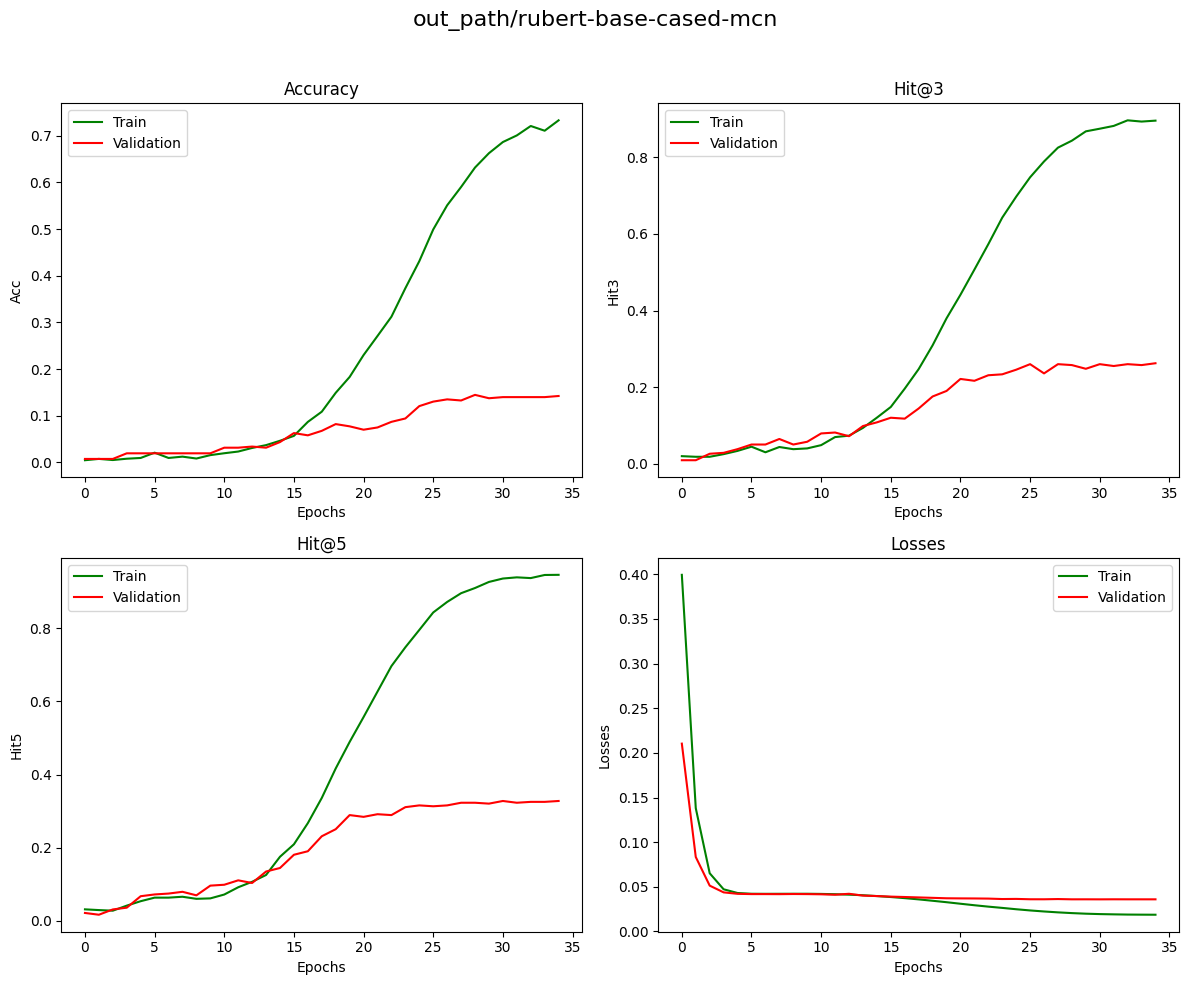

In [287]:
plot_metrics(metrics, 'out_path/rubert-base-cased-mcn')

In [288]:
best_epoch_val, best_acc, best_hit3

(34, 0.2216867469879518, 0.3469879518072289)

In [289]:
model.save_pretrained('out_path/rubert-base-cased-mcn')

In [290]:
del model; 
gc.collect(); 
torch.cuda.empty_cache()

## **8) sagteam/xlm-roberta-large-sag**

In [291]:
model = XLMRobertaForSequenceClassification.from_pretrained('sagteam/xlm-roberta-large-sag', num_labels=141)
model = model.cuda()

tokenizer = XLMRobertaTokenizer.from_pretrained(
    'sagteam/xlm-roberta-large-sag',
    do_lower_case=True,
    max_length=MAX_LEN
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sagteam/xlm-roberta-large-sag and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [292]:
epochs = 40
batch_size = 8
lr = 2e-5
data_path = '/home/kirill/Bert_v2/data'

In [293]:
model, metrics, best_epoch_val, best_hit3, best_acc= train_model(model, 
                                                    tokenizer, 
                                                    epochs, 
                                                    batch_size, 
                                                    lr, 
                                                    data_path) 

len(total) 3300
len(l2i) 141
0


  2%|▎         | 1/40 [02:27<1:35:40, 147.20s/it]

UPDATE: epoch =  0 best_acc =  0.014457831325301205 best_hit3 =  0.021686746987951807
epoch  0 train_loss 0.37675086908412003 val acc 0.0024096385542168677 val hit3 0.016867469879518072


  5%|▌         | 2/40 [04:54<1:33:15, 147.24s/it]

UPDATE: epoch =  1 best_acc =  0.0024096385542168677 best_hit3 =  0.016867469879518072
epoch  1 train_loss 0.17928020571070205 val acc 0.007228915662650603 val hit3 0.014457831325301205


  8%|▊         | 3/40 [07:21<1:30:49, 147.28s/it]

UPDATE: epoch =  2 best_acc =  0.0024096385542168677 best_hit3 =  0.007228915662650603
epoch  2 train_loss 0.10061647601011416 val acc 0.007228915662650603 val hit3 0.01927710843373494


 10%|█         | 4/40 [09:42<1:26:49, 144.71s/it]

epoch  3 train_loss 0.06459813546940409 val acc 0.007228915662650603 val hit3 0.01927710843373494


 12%|█▎        | 5/40 [12:10<1:25:05, 145.86s/it]

UPDATE: epoch =  4 best_acc =  0.0024096385542168677 best_hit3 =  0.024096385542168676
epoch  4 train_loss 0.050298785682368695 val acc 0.007228915662650603 val hit3 0.024096385542168676


 15%|█▌        | 6/40 [14:37<1:22:53, 146.29s/it]

UPDATE: epoch =  5 best_acc =  0.007228915662650603 best_hit3 =  0.03855421686746988
epoch  5 train_loss 0.04491467793420475 val acc 0.014457831325301205 val hit3 0.03614457831325301


 18%|█▊        | 7/40 [16:58<1:19:29, 144.54s/it]

epoch  6 train_loss 0.042903915680939535 val acc 0.00963855421686747 val hit3 0.04096385542168675


 20%|██        | 8/40 [19:19<1:16:30, 143.45s/it]

epoch  7 train_loss 0.04230853979376162 val acc 0.01927710843373494 val hit3 0.02891566265060241


 22%|██▎       | 9/40 [21:47<1:14:45, 144.69s/it]

UPDATE: epoch =  8 best_acc =  0.01927710843373494 best_hit3 =  0.060240963855421686
epoch  8 train_loss 0.04216583972188571 val acc 0.01927710843373494 val hit3 0.060240963855421686


 25%|██▌       | 10/40 [24:14<1:12:46, 145.55s/it]

UPDATE: epoch =  9 best_acc =  0.01927710843373494 best_hit3 =  0.05301204819277108
epoch  9 train_loss 0.042125005449466145 val acc 0.01927710843373494 val hit3 0.06746987951807229


 28%|██▊       | 11/40 [26:35<1:09:38, 144.10s/it]

epoch  10 train_loss 0.04205709639817125 val acc 0.01927710843373494 val hit3 0.03855421686746988


 30%|███       | 12/40 [28:56<1:06:52, 143.30s/it]

epoch  11 train_loss 0.042094222902298556 val acc 0.03132530120481928 val hit3 0.05060240963855422


 32%|███▎      | 13/40 [31:17<1:04:08, 142.55s/it]

epoch  12 train_loss 0.042115767390750965 val acc 0.01927710843373494 val hit3 0.02891566265060241


 35%|███▌      | 14/40 [33:38<1:01:36, 142.17s/it]

epoch  13 train_loss 0.042096062730511453 val acc 0.01927710843373494 val hit3 0.05301204819277108


 38%|███▊      | 15/40 [35:59<59:04, 141.80s/it]  

epoch  14 train_loss 0.042120180856431225 val acc 0.024096385542168676 val hit3 0.05301204819277108


 40%|████      | 16/40 [38:26<57:20, 143.35s/it]

UPDATE: epoch =  15 best_acc =  0.043373493975903614 best_hit3 =  0.10120481927710843
epoch  15 train_loss 0.041753796303251316 val acc 0.03855421686746988 val hit3 0.0819277108433735


 42%|████▎     | 17/40 [40:53<55:21, 144.41s/it]

UPDATE: epoch =  16 best_acc =  0.06506024096385542 best_hit3 =  0.1566265060240964
epoch  16 train_loss 0.041151277623739525 val acc 0.05060240963855422 val hit3 0.12048192771084337


 45%|████▌     | 18/40 [43:20<53:15, 145.23s/it]

UPDATE: epoch =  17 best_acc =  0.07710843373493977 best_hit3 =  0.17349397590361446
epoch  17 train_loss 0.04004193847415828 val acc 0.06746987951807229 val hit3 0.15903614457831325


 48%|████▊     | 19/40 [45:48<51:02, 145.84s/it]

UPDATE: epoch =  18 best_acc =  0.0746987951807229 best_hit3 =  0.21204819277108433
epoch  18 train_loss 0.03874256361107441 val acc 0.06987951807228916 val hit3 0.18795180722891566


 50%|█████     | 20/40 [48:15<48:45, 146.26s/it]

UPDATE: epoch =  19 best_acc =  0.11325301204819277 best_hit3 =  0.2674698795180723
epoch  19 train_loss 0.037270755789875286 val acc 0.09879518072289156 val hit3 0.22409638554216868


 52%|█████▎    | 21/40 [50:42<46:23, 146.49s/it]

UPDATE: epoch =  20 best_acc =  0.1180722891566265 best_hit3 =  0.28674698795180725
epoch  20 train_loss 0.03555768660469264 val acc 0.10120481927710843 val hit3 0.236144578313253


 55%|█████▌    | 22/40 [53:09<44:00, 146.67s/it]

UPDATE: epoch =  21 best_acc =  0.15903614457831325 best_hit3 =  0.3228915662650602
epoch  21 train_loss 0.0338822602567618 val acc 0.1566265060240964 val hit3 0.28674698795180725


 57%|█████▊    | 23/40 [55:36<41:35, 146.77s/it]

UPDATE: epoch =  22 best_acc =  0.17349397590361446 best_hit3 =  0.35903614457831323
epoch  22 train_loss 0.031920961269775006 val acc 0.15180722891566265 val hit3 0.30120481927710846


 60%|██████    | 24/40 [58:03<39:11, 146.95s/it]

UPDATE: epoch =  23 best_acc =  0.21927710843373494 best_hit3 =  0.3783132530120482
epoch  23 train_loss 0.02989963680145982 val acc 0.1710843373493976 val hit3 0.3397590361445783


 62%|██████▎   | 25/40 [1:00:31<36:45, 147.05s/it]

UPDATE: epoch =  24 best_acc =  0.23132530120481928 best_hit3 =  0.41445783132530123
epoch  24 train_loss 0.027877168187290687 val acc 0.19036144578313252 val hit3 0.3469879518072289


 65%|██████▌   | 26/40 [1:02:58<34:19, 147.13s/it]

UPDATE: epoch =  25 best_acc =  0.25060240963855424 best_hit3 =  0.42409638554216866
epoch  25 train_loss 0.02577176009505876 val acc 0.22650602409638554 val hit3 0.38795180722891565


 68%|██████▊   | 27/40 [1:05:19<31:28, 145.26s/it]

epoch  26 train_loss 0.02373301064545717 val acc 0.2216867469879518 val hit3 0.3686746987951807


 70%|███████   | 28/40 [1:07:46<29:09, 145.77s/it]

UPDATE: epoch =  27 best_acc =  0.26506024096385544 best_hit3 =  0.44096385542168676
epoch  27 train_loss 0.021911222492599164 val acc 0.24819277108433735 val hit3 0.38313253012048193


 72%|███████▎  | 29/40 [1:10:13<26:48, 146.20s/it]

UPDATE: epoch =  28 best_acc =  0.2819277108433735 best_hit3 =  0.4506024096385542
epoch  28 train_loss 0.020287193734326144 val acc 0.25301204819277107 val hit3 0.40481927710843374


 75%|███████▌  | 30/40 [1:12:40<24:25, 146.55s/it]

UPDATE: epoch =  29 best_acc =  0.27710843373493976 best_hit3 =  0.4674698795180723
epoch  29 train_loss 0.018813650156768565 val acc 0.25783132530120484 val hit3 0.4


 78%|███████▊  | 31/40 [1:15:01<21:43, 144.81s/it]

epoch  30 train_loss 0.017571547685946074 val acc 0.2385542168674699 val hit3 0.38795180722891565


 80%|████████  | 32/40 [1:17:28<19:23, 145.47s/it]

UPDATE: epoch =  31 best_acc =  0.2963855421686747 best_hit3 =  0.472289156626506
epoch  31 train_loss 0.016606999678742854 val acc 0.26265060240963856 val hit3 0.40481927710843374


 82%|████████▎ | 33/40 [1:19:49<16:47, 143.99s/it]

epoch  32 train_loss 0.015664153608244347 val acc 0.25060240963855424 val hit3 0.3855421686746988


 85%|████████▌ | 34/40 [1:22:09<14:18, 143.00s/it]

epoch  33 train_loss 0.014970863317046144 val acc 0.2674698795180723 val hit3 0.3927710843373494


 88%|████████▊ | 35/40 [1:24:37<12:01, 144.25s/it]

UPDATE: epoch =  34 best_acc =  0.3180722891566265 best_hit3 =  0.4578313253012048
epoch  34 train_loss 0.014479438814183858 val acc 0.26987951807228916 val hit3 0.4072289156626506


 90%|█████████ | 36/40 [1:26:58<09:33, 143.27s/it]

epoch  35 train_loss 0.014093985364178963 val acc 0.26265060240963856 val hit3 0.4


 92%|█████████▎| 37/40 [1:29:18<07:07, 142.54s/it]

epoch  36 train_loss 0.013833092947392387 val acc 0.2746987951807229 val hit3 0.4


 95%|█████████▌| 38/40 [1:31:39<04:44, 142.02s/it]

epoch  37 train_loss 0.013676100575225187 val acc 0.26265060240963856 val hit3 0.40481927710843374


 98%|█████████▊| 39/40 [1:34:00<02:21, 141.64s/it]

epoch  38 train_loss 0.013547122869477131 val acc 0.26024096385542167 val hit3 0.40481927710843374


100%|██████████| 40/40 [1:36:21<00:00, 144.53s/it]

epoch  39 train_loss 0.013536117297234983 val acc 0.26024096385542167 val hit3 0.4


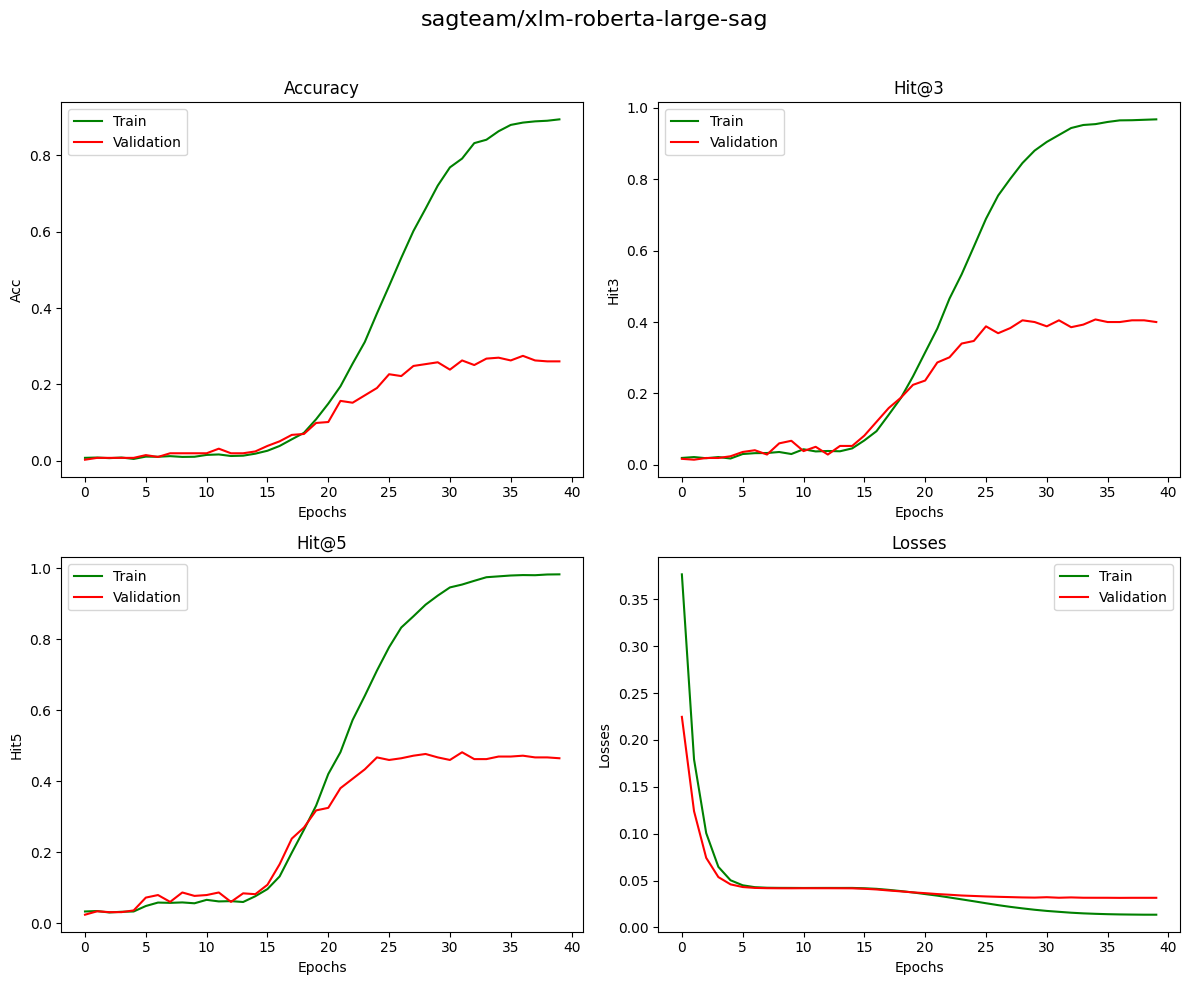

In [294]:
plot_metrics(metrics, 'sagteam/xlm-roberta-large-sag')

In [295]:
best_epoch_val, best_acc, best_hit3

(34, 0.3180722891566265, 0.4578313253012048)

In [296]:
model.save_pretrained('out_path/sagteam-xlm-roberta-large-sag')

In [297]:
del model; 
gc.collect(); 
torch.cuda.empty_cache()

## **9) FacebookAI/xlm-roberta-large**

In [298]:
model = XLMRobertaForSequenceClassification.from_pretrained('FacebookAI/xlm-roberta-large', num_labels=141)
model = model.cuda()

tokenizer = XLMRobertaTokenizer.from_pretrained(
    'FacebookAI/xlm-roberta-large',
    do_lower_case=True,
    max_length=MAX_LEN
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [299]:
epochs = 40
batch_size = 8
lr = 2e-5
data_path = '/home/kirill/Bert_v2/data'

In [300]:
model, metrics, best_epoch_val, best_hit3, best_acc= train_model(model, 
                                                    tokenizer, 
                                                    epochs, 
                                                    batch_size, 
                                                    lr, 
                                                    data_path) 

len(total) 3300
len(l2i) 141
0


  2%|▎         | 1/40 [02:27<1:35:56, 147.61s/it]

UPDATE: epoch =  0 best_acc =  0.004819277108433735 best_hit3 =  0.012048192771084338
epoch  0 train_loss 0.3998506444842503 val acc 0.007228915662650603 val hit3 0.03132530120481928


  5%|▌         | 2/40 [04:54<1:33:17, 147.31s/it]

UPDATE: epoch =  1 best_acc =  0.0024096385542168677 best_hit3 =  0.012048192771084338
epoch  1 train_loss 0.17475210723208112 val acc 0.012048192771084338 val hit3 0.03132530120481928


  8%|▊         | 3/40 [07:15<1:29:01, 144.36s/it]

epoch  2 train_loss 0.09227134843561553 val acc 0.012048192771084338 val hit3 0.03132530120481928


 10%|█         | 4/40 [09:36<1:25:48, 143.02s/it]

epoch  3 train_loss 0.060483139363264514 val acc 0.012048192771084338 val hit3 0.02650602409638554


 12%|█▎        | 5/40 [12:03<1:24:21, 144.62s/it]

UPDATE: epoch =  4 best_acc =  0.0024096385542168677 best_hit3 =  0.02650602409638554
epoch  4 train_loss 0.048603934457787316 val acc 0.012048192771084338 val hit3 0.033734939759036145


 15%|█▌        | 6/40 [14:31<1:22:28, 145.55s/it]

UPDATE: epoch =  5 best_acc =  0.01927710843373494 best_hit3 =  0.04578313253012048
epoch  5 train_loss 0.04422852992432334 val acc 0.00963855421686747 val hit3 0.03855421686746988


 18%|█▊        | 7/40 [16:58<1:20:23, 146.16s/it]

UPDATE: epoch =  6 best_acc =  0.01927710843373494 best_hit3 =  0.05301204819277108
epoch  6 train_loss 0.04268021417160996 val acc 0.01927710843373494 val hit3 0.05060240963855422


 20%|██        | 8/40 [19:19<1:17:02, 144.47s/it]

epoch  7 train_loss 0.04220142994430479 val acc 0.01927710843373494 val hit3 0.05060240963855422


 22%|██▎       | 9/40 [21:47<1:15:08, 145.44s/it]

UPDATE: epoch =  8 best_acc =  0.014457831325301205 best_hit3 =  0.05301204819277108
epoch  8 train_loss 0.042132043913150986 val acc 0.021686746987951807 val hit3 0.06746987951807229


 25%|██▌       | 10/40 [24:08<1:12:02, 144.07s/it]

epoch  9 train_loss 0.04213363374906732 val acc 0.01927710843373494 val hit3 0.02891566265060241


 28%|██▊       | 11/40 [26:29<1:09:14, 143.27s/it]

epoch  10 train_loss 0.042121346344369134 val acc 0.00963855421686747 val hit3 0.05060240963855422


 30%|███       | 12/40 [28:50<1:06:33, 142.61s/it]

epoch  11 train_loss 0.04214452917643127 val acc 0.00963855421686747 val hit3 0.02891566265060241


 32%|███▎      | 13/40 [31:11<1:03:57, 142.13s/it]

epoch  12 train_loss 0.042055098006381436 val acc 0.01927710843373494 val hit3 0.05542168674698795


 35%|███▌      | 14/40 [33:32<1:01:27, 141.83s/it]

epoch  13 train_loss 0.042131731203664 val acc 0.01927710843373494 val hit3 0.03855421686746988


 38%|███▊      | 15/40 [35:54<59:04, 141.78s/it]  

epoch  14 train_loss 0.04213735508706442 val acc 0.01927710843373494 val hit3 0.05060240963855422


 40%|████      | 16/40 [38:15<56:38, 141.59s/it]

epoch  15 train_loss 0.042122526654235305 val acc 0.021686746987951807 val hit3 0.05301204819277108


 42%|████▎     | 17/40 [40:43<54:57, 143.38s/it]

UPDATE: epoch =  16 best_acc =  0.04578313253012048 best_hit3 =  0.10602409638554217
epoch  16 train_loss 0.04185943031209438 val acc 0.03855421686746988 val hit3 0.09156626506024096


 45%|████▌     | 18/40 [43:04<52:16, 142.59s/it]

epoch  17 train_loss 0.04138212041758202 val acc 0.02891566265060241 val hit3 0.0963855421686747


 48%|████▊     | 19/40 [45:31<50:24, 144.03s/it]

UPDATE: epoch =  18 best_acc =  0.05783132530120482 best_hit3 =  0.15421686746987953
epoch  18 train_loss 0.04065857108592646 val acc 0.05060240963855422 val hit3 0.13012048192771083


 50%|█████     | 20/40 [47:52<47:41, 143.06s/it]

epoch  19 train_loss 0.03976041716011197 val acc 0.043373493975903614 val hit3 0.12771084337349398


 52%|█████▎    | 21/40 [50:19<45:42, 144.34s/it]

UPDATE: epoch =  20 best_acc =  0.07228915662650602 best_hit3 =  0.20240963855421687
epoch  20 train_loss 0.03871876683109497 val acc 0.06746987951807229 val hit3 0.17590361445783131


 55%|█████▌    | 22/40 [52:46<43:32, 145.15s/it]

UPDATE: epoch =  21 best_acc =  0.08674698795180723 best_hit3 =  0.20722891566265061
epoch  21 train_loss 0.03761061778754218 val acc 0.08433734939759036 val hit3 0.19036144578313252


 57%|█████▊    | 23/40 [55:13<41:18, 145.81s/it]

UPDATE: epoch =  22 best_acc =  0.10361445783132531 best_hit3 =  0.236144578313253
epoch  22 train_loss 0.03653799577581519 val acc 0.10843373493975904 val hit3 0.24819277108433735


 60%|██████    | 24/40 [57:34<38:28, 144.28s/it]

epoch  23 train_loss 0.035454782110325454 val acc 0.0891566265060241 val hit3 0.22650602409638554


 62%|██████▎   | 25/40 [1:00:02<36:19, 145.30s/it]

UPDATE: epoch =  24 best_acc =  0.12530120481927712 best_hit3 =  0.2891566265060241
epoch  24 train_loss 0.03411773712664961 val acc 0.1108433734939759 val hit3 0.25060240963855424


 65%|██████▌   | 26/40 [1:02:30<34:04, 146.02s/it]

UPDATE: epoch =  25 best_acc =  0.1493975903614458 best_hit3 =  0.327710843373494
epoch  25 train_loss 0.03281644520780804 val acc 0.12289156626506025 val hit3 0.28433734939759037


 68%|██████▊   | 27/40 [1:04:57<31:44, 146.50s/it]

UPDATE: epoch =  26 best_acc =  0.1614457831325301 best_hit3 =  0.327710843373494
epoch  26 train_loss 0.03197727606251247 val acc 0.1493975903614458 val hit3 0.28674698795180725


 70%|███████   | 28/40 [1:07:25<29:21, 146.78s/it]

UPDATE: epoch =  27 best_acc =  0.1710843373493976 best_hit3 =  0.3301204819277108
epoch  27 train_loss 0.030574206376774243 val acc 0.14216867469879518 val hit3 0.3156626506024096


 72%|███████▎  | 29/40 [1:09:52<26:56, 146.92s/it]

UPDATE: epoch =  28 best_acc =  0.1710843373493976 best_hit3 =  0.3566265060240964
epoch  28 train_loss 0.029258259884781146 val acc 0.16626506024096385 val hit3 0.3397590361445783


 75%|███████▌  | 30/40 [1:12:13<24:10, 145.09s/it]

epoch  29 train_loss 0.028068605618527438 val acc 0.1710843373493976 val hit3 0.3301204819277108


 78%|███████▊  | 31/40 [1:14:40<21:51, 145.77s/it]

UPDATE: epoch =  30 best_acc =  0.20963855421686747 best_hit3 =  0.39036144578313253
epoch  30 train_loss 0.02709588303255443 val acc 0.19036144578313252 val hit3 0.35180722891566263


 80%|████████  | 32/40 [1:17:07<19:29, 146.22s/it]

UPDATE: epoch =  31 best_acc =  0.21445783132530122 best_hit3 =  0.35180722891566263
epoch  31 train_loss 0.026122285222957623 val acc 0.19759036144578312 val hit3 0.3614457831325301


 82%|████████▎ | 33/40 [1:19:28<16:52, 144.62s/it]

epoch  32 train_loss 0.02521836846794359 val acc 0.1855421686746988 val hit3 0.35903614457831323


 85%|████████▌ | 34/40 [1:21:55<14:32, 145.40s/it]

UPDATE: epoch =  33 best_acc =  0.22409638554216868 best_hit3 =  0.3783132530120482
epoch  33 train_loss 0.024654747863077222 val acc 0.2 val hit3 0.3686746987951807


 88%|████████▊ | 35/40 [1:24:17<12:00, 144.16s/it]

epoch  34 train_loss 0.02408828286380365 val acc 0.20240963855421687 val hit3 0.3566265060240964


 90%|█████████ | 36/40 [1:26:38<09:33, 143.29s/it]

epoch  35 train_loss 0.02371163534861205 val acc 0.2 val hit3 0.363855421686747


 92%|█████████▎| 37/40 [1:28:59<07:07, 142.60s/it]

epoch  36 train_loss 0.02342888602511148 val acc 0.20481927710843373 val hit3 0.3614457831325301


 95%|█████████▌| 38/40 [1:31:20<04:44, 142.06s/it]

epoch  37 train_loss 0.023277199638493107 val acc 0.20481927710843373 val hit3 0.35903614457831323


 98%|█████████▊| 39/40 [1:33:41<02:21, 141.76s/it]

epoch  38 train_loss 0.023201854342194208 val acc 0.20240963855421687 val hit3 0.35903614457831323


100%|██████████| 40/40 [1:36:02<00:00, 144.06s/it]

epoch  39 train_loss 0.023124204990932738 val acc 0.20240963855421687 val hit3 0.35903614457831323


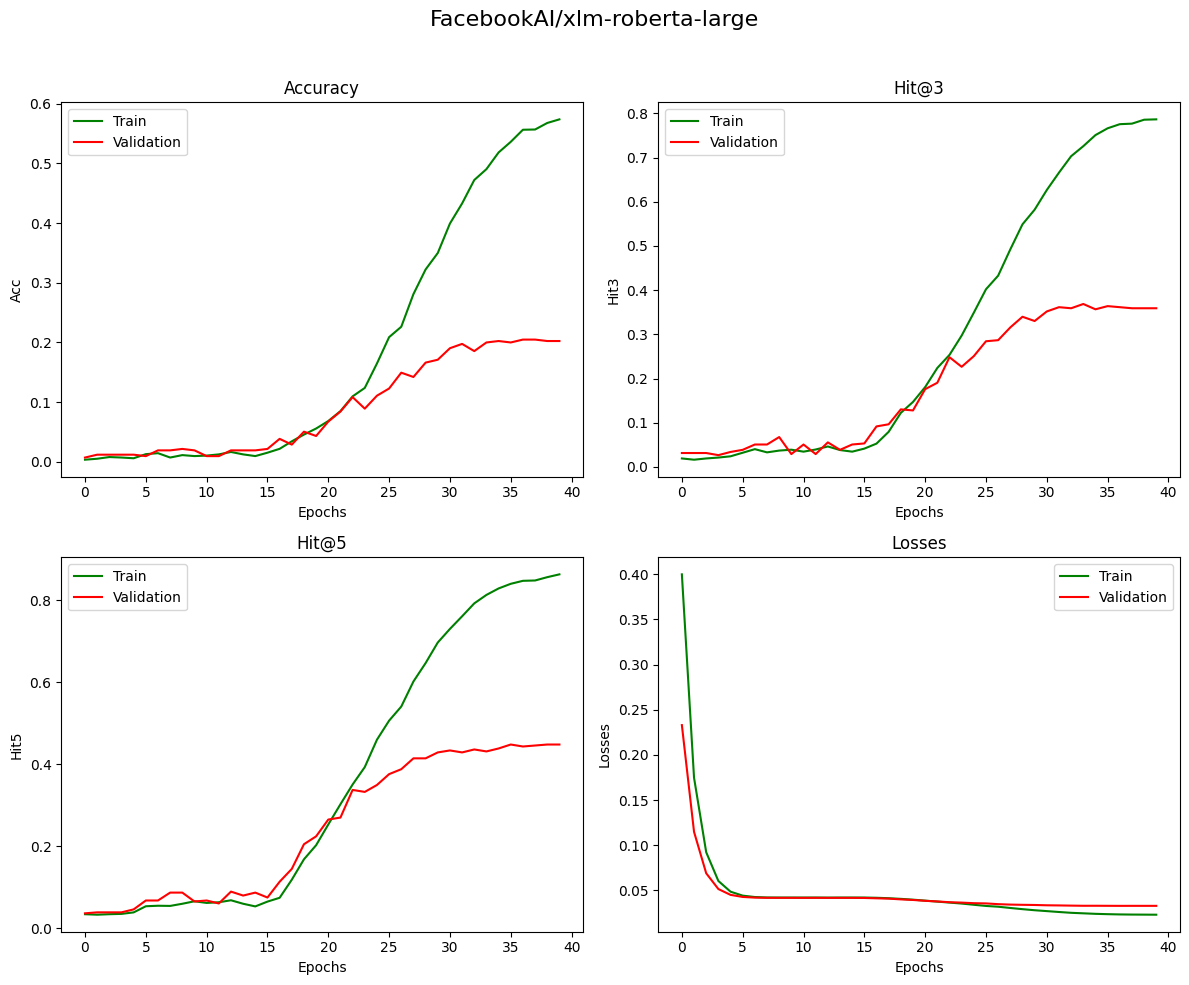

In [301]:
plot_metrics(metrics, 'FacebookAI/xlm-roberta-large')

In [302]:
best_epoch_val, best_acc, best_hit3

(33, 0.22409638554216868, 0.3783132530120482)

In [303]:
model.save_pretrained('out_path/FacebookAI-xlm-roberta-large')

In [304]:
del model; 
gc.collect(); 
torch.cuda.empty_cache()

## **10) Пример работы модели**

Возьмем один из примеров. Текст примера содержит множество симптомов. Посмотрим какие модели посчитает более релевантными.

In [117]:
sentence = 'жалобы сохраняются прежние : выраженные боли в правой руке, в правом плечевом суставе, локтевом суставе, ограничение движений в правом плечевом суставе, при движениях правой рукой : сгибании , разгибании, поднимании руки вверх - усиливаются боли в  и локтевом суставах по ВАШ 10 баллоов, также сохраняется боль и онемение 4 и 5 пальцев правой руки, простреливающего характера. Головные боли сохраняются, выраженные, преимущественно в затылочной области, постоянные. Лечение получает переносит хорошо. Уменьшились боли в шейном отделе позвоночника'
label = 'боль в области плеча'

In [118]:
print(' TEXT:', sentence, '\n\n' , 'LABEL:', label)

 TEXT: жалобы сохраняются прежние : выраженные боли в правой руке, в правом плечевом суставе, локтевом суставе, ограничение движений в правом плечевом суставе, при движениях правой рукой : сгибании , разгибании, поднимании руки вверх - усиливаются боли в  и локтевом суставах по ВАШ 10 баллоов, также сохраняется боль и онемение 4 и 5 пальцев правой руки, простреливающего характера. Головные боли сохраняются, выраженные, преимущественно в затылочной области, постоянные. Лечение получает переносит хорошо. Уменьшились боли в шейном отделе позвоночника 

 LABEL: боль в области плеча


In [119]:
model_predict = XLMRobertaForSequenceClassification.from_pretrained('out_path/sagteam-xlm-roberta-large-sag', num_labels=141)
tokenizer = XLMRobertaTokenizer.from_pretrained(
    'sagteam/xlm-roberta-large-sag',
    do_lower_case=True,
    max_length=MAX_LEN
)

In [140]:
def predict(sentence, k):
    
    text1_id, label_id, index_id = 'symptoms', 'code', 'idx'
    parts = ['train', 'dev', 'test']

    part2indices = {p:set() for p in parts}
    all_ids, sentences, labels = [], [], []
    for p in parts:
        fname = '{}_v1.jsonl'.format(p)
        with open(os.path.join(data_path, fname)) as f:
            for line in f:
                data = json.loads(line)
                s1 = data[text1_id]
                sentences.append( s1 )
                labels.append( data[label_id] )
                idx = data[index_id]
                all_ids.append( idx )
                part2indices[p].add( idx )
    all_ids = np.array(all_ids)
    
    code_set = set(labels)
    l2i = {code:i for i, code in enumerate(sorted(code_set))}
    i2l = {l2i[l]:l for l in l2i}
    
    input_ids, attention_masks = encode_texts(tokenizer, [sentence])
    input_ids = torch.tensor(input_ids).long()
    attention_masks = torch.tensor(attention_masks).long()
    #lab = torch.tensor([label, dtype=torch.float64)
    
    logit = model_predict(input_ids, attention_mask=attention_masks, labels=torch.zeros(1, 141))[1]
    top_k = np.argsort(logit[0].detach())[-k:].numpy()
    result = [i2l[t] for t in top_k]
    
    return result[::-1]

In [141]:
predict(sentence, 1)

['боль в области плеча']

In [142]:
predict(sentence, 3)

['боль в области плеча', 'боль в области лопатки', 'стреляющая боль']

Как мы видим модель достаточно точно определяет группу симптомов относящихся к тексту

## **11) Результаты**

Полученные результаты acc/hit@(%):

* RuBERT: 19.28, 34.46
* RuBioRoBERTa : 20.24, 39.52
* rubert-base-cased-mcn 22.17, 34.69
* sagteam/xlm-roberta-large-sag 31.81, 45.78
* FacebookAI/xlm-roberta-large 22.41, 37.83

## **12) Ссылки на источники**

* [1] - https://arxiv.org/abs/2201.06499
* [2] - https://zenodo.org/records/5765873#.YbBlXT9Bzmw
* [3] - https://arxiv.org/abs/1905.07213
* [4] - https://arxiv.org/abs/2204.03951
* [5] - https://github.com/sb-ai-lab/MedBench/tree/main
* [6] - https://arxiv.org/pdf/1412.6980
* [7] - https://arxiv.org/pdf/1708.07120